#Functions and imports

**Installing dependencies**

*Run these cells if this is the first time that this notebook is being executed.*

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
import pandas as pd
import itertools
import matplotlib.pyplot as plt

np.random.seed(100)

#Random Forests
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

#Error eval
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy import stats

#Extra optimizer
from sklearn.linear_model import OrthogonalMatchingPursuit

#Danger zone:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##Definitions

In [ ]:
default_pysr_params = dict(
    populations=50,
    model_selection="best",
)

All structures below are quite similar, but we need to have a cell for each dynamics to take the equations into consideration correctly.

In [ ]:
def volterra(t, y, a=2, b=0.5, c=1, d=0.375):
  u,v = y
  dudt = a*u - b*u*v
  dvdt = -c*v + d*b*u*v

  return [dudt, dvdt]

In [ ]:
def pendulum(t, y):
    theta, omega = y
    g = 9.8
    L = 1.0

    d_theta = omega
    d_omega = - (g / L) * np.sin(theta)

    return [d_theta, d_omega]

In [ ]:
def lorenz(t, ivp_sol, sigma=2.0, rho=1.0, beta=2.6):
  x, y, z = ivp_sol
  dx_dt = sigma * (y - x)
  dy_dt = x * (rho - z) - y
  dz_dt = x * y - beta * z

  return [dx_dt, dy_dt, dz_dt]

In [ ]:
#=== SIS ===
def sis(t, y, beta = 0.3, gamma = 0.1):
  S, I = y
  dSdt = -beta * S * I + gamma * I
  dIdt = beta * S * I - gamma * I
  return [dSdt, dIdt]

In [ ]:
#=== SIR ===
def sir(t, y, beta=0.3, gamma=0.1):
  S, I, R = y
  dSdt = -beta * S * I
  dIdt = beta * S * I - gamma * I
  dRdt = gamma*I
  return [dSdt, dIdt, dRdt]

In [ ]:
#=== SEIR ===
def seir(t, y, beta=0.3, alpha=0.2, gamma=1.0):
    S, E, I, R = y
    dSdt = -beta * S * I
    dEdt = beta * S * I - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

In [ ]:
 #=== SEIRD ===
def seird(t, y, beta=0.3, alpha=0.2, gamma=1.0, mu=0.1):
    S, E, I, R, D = y
    dSdt = -beta * S * I
    dEdt = beta * S * I - alpha * E
    dIdt = alpha * E - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

In [ ]:
 #=== SIRV ===
def sirv(t, y, beta=0.5, gamma=1.0, nu=0.5):
    S, I, R, V = y
    dSdt = -beta * S * I - nu * S
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    dVdt = nu * S
    return [dSdt, dIdt, dRdt, dVdt]

In [ ]:
 #=== SIRS ===
def sirs(t, y, beta=0.3, gamma=1.0, nu=0.2):
    S, I, R = y
    dSdt = -beta * S * I + nu * R
    dIdt =  beta * S * I - gamma * I
    dRdt = gamma * I- nu * R
    return [dSdt, dIdt, dRdt]

##Error evaluation

In [ ]:
def error_eval(model, dyn_name, curves_names, test_set):
  '''
  This function assumes you've run a grid search fit for the RF model previously.
  -> test_set should be [X_test, y_test]
  '''

  #Metrics
  mse = []
  mae = []
  r2 = []
  rmse = []
  statistics = []
  p_values = []
  wilcoxon_sol = []

  #Predict for each model found
  y_preds = model.predict(test_set[0]).transpose()

  #y_int = model.predict(init_params)
  len_sol = len(y_preds)

  for i in range(len_sol):
    mse.append(mean_squared_error(y_preds[i], test_set[1][i]))
    mae.append(mean_absolute_error(y_preds[i], test_set[1][i]))
    if (r2_score(y_preds[i], test_set[1][i]) < 0):
      r2.append(0)
    else:
      r2.append(r2_score(y_preds[i], test_set[1][i]))
    rmse.append(np.sqrt(mean_squared_error(y_preds[i], test_set[1][i])))

    #Wilcoxon test
    statistic, p_value = stats.wilcoxon(test_set[1][i], y_preds[i])
    statistics.append(statistic)
    p_values.append(p_value)

    if p_value < 0.05:
      wilcoxon_sol.append(1)
    else:
      wilcoxon_sol.append(0)


  res = pd.DataFrame(data={'dynamics': np.repeat(dyn_name,len_sol), 'axis': curves_names,
                           'mae': mae, 'mse': mse, 'r2': r2, 'rmse':rmse,
                           'wilcoxon_raw_value': statistics,
                           'p-value': p_values,
                           'is_difference': wilcoxon_sol})

  return res

#Dynamics to investigate

##Lorenz

In [ ]:
#Parameters
feature_names = ['X', 'Y', 'Z']
t_start = 0.0
t_end = 5.0
t_step = 0.02
t_eval = np.arange(t_start, t_end, t_step)
t_span = (t_start, t_end)

x0, y0, z0 = 0.6, 2.0, 1.0  # Condições iniciais
state0 = [x0, y0, z0]

In [ ]:
#Solve the system
solution = solve_ivp(lorenz, t_span, state0, method='RK45', t_eval=t_eval)

#Target variables
dxdt = lorenz([0], solution.y)[0]
dydt = lorenz([0], solution.y)[1]
dzdt = lorenz([0], solution.y)[2]
targets = [dxdt,dydt,dzdt]

In [ ]:
#Baseline Random Forest regression
X = pd.DataFrame(solution.y.T)
y = pd.DataFrame(targets).transpose()

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    shuffle=True, random_state=42)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

param_grid = {'estimator__n_estimators':[10,25,50,100,150,200,300],
              'estimator__min_weight_fraction_leaf': [0.0, 0.25, 0.5],
              'estimator__max_features': ['sqrt','log2',None]}

grid = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), param_grid=param_grid, n_jobs=-1, cv=5)
rf = grid.fit(x_train_scaled, y_train)

In [ ]:
res = error_eval(rf, 'Lorenz', feature_names, test_set=[x_test_scaled,y_test])
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,Lorenz,X,0.111813,0.061934,0.826581,0.248865,843.0,2.586418e-01,0
1,Lorenz,Y,0.048225,0.008229,0.968011,0.090714,25.0,1.699895e-11,1
2,Lorenz,Z,0.039357,0.008475,0.834687,0.092061,143.0,3.182818e-09,1


##Lotka-Volterra

In [ ]:
#Parameters
feature_names = ['u', 'v']

t_start = 0.0
t_end = 7.5
t_step = 0.1
t_eval = np.arange(t_start, t_end, t_step)
t_span = (t_start, t_end)

state0 = np.array([20, 5])

In [ ]:
#Solve the system
solution = solve_ivp(volterra, t_span, state0, t_eval=t_eval)

#Target variables
dudt = volterra([0], solution.y)[0]
dvdt = volterra([0], solution.y)[1]
targets = [dudt,dvdt]

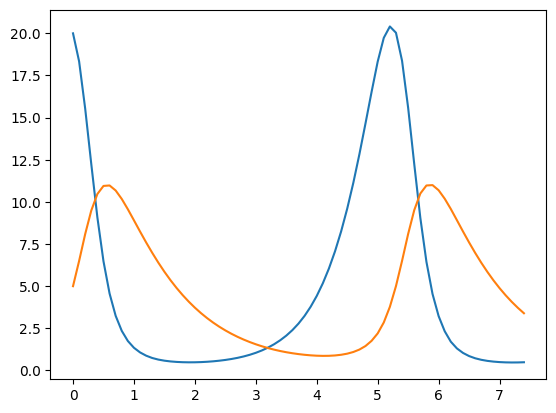

In [ ]:
plt.plot(t_eval,solution.y[0])
plt.plot(t_eval,solution.y[1])

In [ ]:
#Baseline Random Forest regression
X = pd.DataFrame(solution.y.T)
y = pd.DataFrame(targets).transpose()

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    shuffle=True, random_state=42)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

param_grid = {'estimator__n_estimators':[10,25,50,100,150,200,300],
              'estimator__min_weight_fraction_leaf': [0.0, 0.25, 0.5],
              'estimator__max_features': ['sqrt','log2',None]}

grid = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), param_grid=param_grid, n_jobs=-1, cv=5)
rf = grid.fit(x_train_scaled, y_train)

In [ ]:
res = error_eval(rf, 'Lotka-Volterra', feature_names, test_set=[x_test_scaled,y_test])
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,Lotka-Volterra,u,1.334899,4.663372,0.96028,2.159484,88.0,0.798252,0
1,Lotka-Volterra,v,0.703280,1.330426,0.95467,1.153441,86.0,0.738091,0


##Simple pendulum

In [ ]:
#Parameters
feature_names = ['theta', 'omega']

t_start = 0.0
t_end = 10
t_step = 0.01
t_eval = np.arange(t_start, t_end, t_step)
t_span = (t_start, t_end)

state0 = np.array([np.radians(45), 0])

In [ ]:
#Solve the system
solution = solve_ivp(pendulum, t_span, state0, t_eval=t_eval)

#Target variables
dthetadt = pendulum([0], solution.y)[0]
domegadt = pendulum([0], solution.y)[1]
targets = [dthetadt,domegadt]

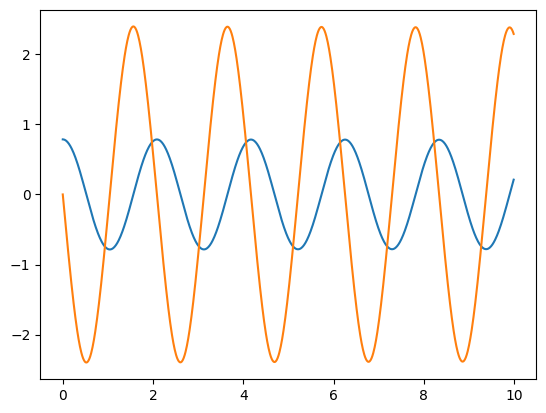

In [ ]:
plt.plot(t_eval,solution.y[0])
plt.plot(t_eval,solution.y[1])

In [ ]:
#Baseline Random Forest regression
X = pd.DataFrame(solution.y.T)
y = pd.DataFrame(targets).transpose()

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    shuffle=True, random_state=42)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

param_grid = {'estimator__n_estimators':[10,25,50,100,150,200,300],
              'estimator__min_weight_fraction_leaf': [0.0, 0.25, 0.5],
              'estimator__max_features': ['sqrt','log2',None]}

grid = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), param_grid=param_grid, n_jobs=-1, cv=5)
rf = grid.fit(x_train_scaled, y_train)

In [ ]:
res = error_eval(rf, 'Pendulum', feature_names, test_set=[x_test_scaled,y_test])
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,Pendulum,theta,0.003622,0.000019,0.999993,0.004411,14489.0,0.295020,0
1,Pendulum,omega,0.011715,0.000226,0.999991,0.015030,13907.0,0.119783,0


##SIR

In [ ]:
#Parameters
feature_names = ['S', 'I', 'R']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0 = 0.001, 0.0
S0 = N - I0 - R0
x0 = np.array([S0, I0, R0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta=0.3
gamma=0.1

In [ ]:
#Solve the SIR system
solution = solve_ivp(sir, t_span, x0, t_eval=t_eval)

#Target variables
dSdt = sir([0], solution.y)[0]
dIdt = sir([0], solution.y)[1]
dRdt = sir([0], solution.y)[2]
targets = [dSdt,dIdt,dRdt]

In [ ]:
#Baseline Random Forest regression
X = pd.DataFrame(solution.y.T)
y = pd.DataFrame(targets).transpose()

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    shuffle=True, random_state=42)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

param_grid = {'estimator__n_estimators':[10,25,50,100,150,200,300],
              'estimator__min_weight_fraction_leaf': [0.0, 0.25, 0.5],
              'estimator__max_features': ['sqrt','log2',None]}

grid = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), param_grid=param_grid, n_jobs=-1, cv=5)
rf = grid.fit(x_train_scaled, y_train)

In [ ]:
res = error_eval(rf, 'SIR', feature_names, test_set=[x_test_scaled,y_test])
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SIR,S,0.000049,1.379631e-08,0.999929,0.000117,5649.0,1.770990e-18,1
1,SIR,I,0.000031,2.984203e-09,0.999962,0.000055,14860.0,4.696701e-01,0
2,SIR,R,0.000034,3.135340e-09,0.999965,0.000056,11127.0,6.757399e-05,1


##SIS

In [ ]:
#Parameters
feature_names = ['S', 'I']
#Time
t = np.linspace(0, 10, 100)
t_start = 0.0
t_end = 100.0
t_step =  0.1
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

#SIS
N = 1
I0 = 0.001
S0 = N - I0
x0 = np.array([S0, I0])

In [ ]:
#Solve the SIS system
solution = solve_ivp(sis, t_span, x0, t_eval=t_eval)

#Target variables
dSdt = sis([0], solution.y)[0]
dIdt = sis([0], solution.y)[1]
targets = [dSdt,dIdt]

In [ ]:
#Baseline Random Forest regression
X = pd.DataFrame(solution.y.T)
y = pd.DataFrame(targets).transpose()

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    shuffle=True, random_state=42)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

param_grid = {'estimator__n_estimators':[10,25,50,100,150,200,300],
              'estimator__min_weight_fraction_leaf': [0.0, 0.25, 0.5],
              'estimator__max_features': ['sqrt','log2',None]}

grid = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), param_grid=param_grid, n_jobs=-1, cv=5)
rf = grid.fit(x_train_scaled, y_train)

In [ ]:
res = error_eval(rf, 'SIS', feature_names, test_set=[x_test_scaled,y_test])
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SIS,S,0.000037,4.309980e-09,0.999965,0.000066,7312.0,2.517498e-13,1
1,SIS,I,0.000035,3.983544e-09,0.999968,0.000063,7536.0,1.061766e-12,1


##SEIR

In [ ]:
#Parameters
feature_names = ['S', 'E', 'I', 'R']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1   #why does it changes here?
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0, E0 = 0.001, 0.0, 0.0
S0 = N - I0 - R0 - E0
x0 = np.array([S0, E0, I0, R0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta = 0.3
gamma = 1.0
alpha = 0.2

In [ ]:
#Solve the SEIR system
solution = solve_ivp(seir, t_span, x0, t_eval=t_eval, args=(0.3, 0.2, 1.0))

#Target variables
dSdt = seir([0], solution.y)[0]
dEdt = seir([0], solution.y)[1]
dIdt = seir([0], solution.y)[2]
dRdt = seir([0], solution.y)[3]
targets = [dSdt,dEdt,dIdt,dRdt]

In [ ]:
#Baseline Random Forest regression
X = pd.DataFrame(solution.y.T)
y = pd.DataFrame(targets).transpose()

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    shuffle=True, random_state=42)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

param_grid = {'estimator__n_estimators':[10,25,50,100,150,200,300],
              'estimator__min_weight_fraction_leaf': [0.0, 0.25, 0.5],
              'estimator__max_features': ['sqrt','log2',None]}

grid = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), param_grid=param_grid, n_jobs=-1, cv=5)
rf = grid.fit(x_train_scaled, y_train)

In [ ]:
res = error_eval(rf, 'SEIR', feature_names, test_set=[x_test_scaled,y_test])
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SEIR,S,8.536977e-07,1.203532e-11,0.981728,0.000003,0.0,9.254425e-43,1
1,SEIR,E,9.158770e-07,1.974899e-11,0.968848,0.000004,9559.0,8.570468e-08,1
2,SEIR,I,2.412103e-06,1.174201e-10,0.982428,0.000011,1097.0,3.188825e-37,1
3,SEIR,R,2.760324e-06,1.176265e-10,0.983577,0.000011,0.0,9.254425e-43,1


##SEIRD

In [ ]:
#Parameters
feature_names = ['S', 'E', 'I', 'R', 'D']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1   #why does it changes here?
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0, E0, D0 = 0.001, 0.0, 0.0, 0.0
S0 = N - I0 - R0 - E0 - D0
x0 = np.array([S0, E0, I0, R0, D0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta = 0.3
gamma = 1.0
alpha = 0.2
mu = 0.1

In [ ]:
#Solve the SEIR system
solution = solve_ivp(seird, t_span, x0, t_eval=t_eval, args=(0.3, 0.2, 1.0, 0.1))

#Target variables
dSdt = seird([0], solution.y)[0]
dEdt = seird([0], solution.y)[1]
dIdt = seird([0], solution.y)[2]
dRdt = seird([0], solution.y)[3]
dDdt = seird([0], solution.y)[3]
targets = [dSdt,dEdt,dIdt,dRdt,dDdt]

In [ ]:
#Baseline Random Forest regression
X = pd.DataFrame(solution.y.T)
y = pd.DataFrame(targets).transpose()

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    shuffle=True, random_state=42)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

param_grid = {'estimator__n_estimators':[10,25,50,100,150,200,300],
              'estimator__min_weight_fraction_leaf': [0.0, 0.25, 0.5],
              'estimator__max_features': ['sqrt','log2',None]}

grid = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), param_grid=param_grid, n_jobs=-1, cv=5)
rf = grid.fit(x_train_scaled, y_train)

In [ ]:
res = error_eval(rf, 'SEIRD', feature_names, test_set=[x_test_scaled,y_test])
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SEIRD,S,8.333386e-07,1.380082e-11,0.977920,0.000004,89.0,2.693904e-42,1
1,SEIRD,E,9.005441e-07,1.703995e-11,0.970674,0.000004,11920.0,9.954915e-04,1
2,SEIRD,I,2.927732e-06,2.163852e-10,0.973475,0.000015,2957.0,9.686083e-29,1
3,SEIRD,R,3.017054e-06,1.961174e-10,0.972957,0.000014,203.0,1.049409e-41,1
4,SEIRD,D,2.415244e-06,9.629493e-11,0.984716,0.000010,151.0,5.650632e-42,1


##SIRV

In [ ]:
#Parameters
feature_names = ['S', 'I', 'R', 'V']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0, V0 = 0.001, 0.0, 0.5
S0 = N - I0 - R0 - V0
x0 = np.array([S0, I0, R0, V0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta=0.3
gamma=0.1
nu=0.5

In [ ]:
#Solve the SIR system
solution = solve_ivp(sirv, t_span, x0, t_eval=t_eval)

#Target variables
dSdt = sirv([0], solution.y)[0]
dIdt = sirv([0], solution.y)[1]
dRdt = sirv([0], solution.y)[2]
dVdt = sirv([0], solution.y)[3]
targets = [dSdt,dIdt,dRdt,dVdt]

In [ ]:
#Baseline Random Forest regression
X = pd.DataFrame(solution.y.T)
y = pd.DataFrame(targets).transpose()

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    shuffle=True, random_state=42)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

param_grid = {'estimator__n_estimators':[10,25,50,100,150,200,300],
              'estimator__min_weight_fraction_leaf': [0.0, 0.25, 0.5],
              'estimator__max_features': ['sqrt','log2',None]}

grid = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), param_grid=param_grid, n_jobs=-1, cv=5)
rf = grid.fit(x_train_scaled, y_train)

In [ ]:
res = error_eval(rf, 'SIRV', feature_names, test_set=[x_test_scaled,y_test])
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SIRV,S,0.000437,3.884998e-06,0.994080,0.001971,9580.0,9.484228e-08,1
1,SIRV,I,0.000001,4.620628e-11,0.990457,0.000007,0.0,9.254425e-43,1
2,SIRV,R,0.000002,1.214886e-10,0.985025,0.000011,1.0,9.366510e-43,1
3,SIRV,V,0.000425,3.666567e-06,0.994385,0.001915,9783.0,2.483118e-07,1


##SIRS

In [ ]:
#Parameters
feature_names = ['S', 'I', 'R']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0 = 0.001, 0.0
S0 = N - I0 - R0
x0 = np.array([S0, I0, R0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta=0.3
gamma=0.1

In [ ]:
#Solve the SIR system
solution = solve_ivp(sirs, t_span, x0, t_eval=t_eval)

#Target variables
dSdt = sirs([0], solution.y)[0]
dIdt = sirs([0], solution.y)[1]
dRdt = sirs([0], solution.y)[2]
targets = [dSdt,dIdt,dRdt]

In [ ]:
#Baseline Random Forest regression
X = pd.DataFrame(solution.y.T)
y = pd.DataFrame(targets).transpose()

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    shuffle=True, random_state=42)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

param_grid = {'estimator__n_estimators':[10,25,50,100,150,200,300],
              'estimator__min_weight_fraction_leaf': [0.0, 0.25, 0.5],
              'estimator__max_features': ['sqrt','log2',None]}

grid = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), param_grid=param_grid, n_jobs=-1, cv=5)
rf = grid.fit(x_train_scaled, y_train)

In [ ]:
res = error_eval(rf, 'SIRS', feature_names, test_set=[x_test_scaled,y_test])
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SIRS,S,4.200254e-07,6.191723e-12,0.995649,0.000002,10689.0,1.257539e-05,1
1,SIRS,I,5.001439e-07,6.520167e-12,0.998116,0.000003,1043.0,1.739166e-37,1
2,SIRS,R,8.510699e-07,2.259919e-11,0.996732,0.000005,7093.0,5.943609e-14,1
